<a href="https://colab.research.google.com/github/AllanKamimura/2021EstudosPython/blob/main/signal/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [1]:
# download example data
from google_drive_downloader import GoogleDriveDownloader

file_id = "1XP6VG6b42PZZzvmqskTpczq2uolPnoNF"

GoogleDriveDownloader.download_file_from_google_drive(
    file_id,
    "./example.zip",
    unzip = True
)


Unzipping...Done.


In [8]:
# clone signal processing utils
!git clone \
--depth 1 \
https://github.com/AllanKamimura/AI.git

Cloning into 'AI'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 91 (delta 6), reused 68 (delta 2), pack-reused 0
Unpacking objects: 100% (91/91), done.
Checking out files: 100% (69/69), done.


In [9]:
from AI.signal.preprocessing import not_keras, my_utils
from AI.signal.models import layers

## Create Dataset
```
── [yourdataset]
        ├── class1
        │     ├── file1.mat
        │     ├── file2.mat
        │     └──  ...
        └── class2
             ├── file3.mat
             ├── file4.mat
             └──  ...
```

In [ ]:
# converts the matlab files (saved signal matrix) to .TIF
# to save a matlab variable containing a matrix, use
# > save file_name.mat variable_name

import os

folders = os.listdir("/content/example")

for folder in folders:
    folder_path = os.path.join("/content/example", folder)
    my_utils.image_save(folder_path, mode = "matlab")

In [ ]:
# converts the csv files (saved signal matrix) to .TIF
# to save a python variable containing a matrix as csv, use
# > np.savetxt("file_name.csv", variable_name, delimiter=",")

import os

folders = os.listdir("/content/example")

for folder in folders:
    folder_path = os.path.join("/content/example", folder)
    my_utils.image_save(folder_path, mode = "csv")

In [123]:
import os
import pathlib
import scipy.io
import numpy as np

from PIL import Image

def read_matlab(matfile):
	"""
	Inputs:
		matfile [path]: path to the matlab file to read
	
	Outputs:
		matrix [Numpy.narray]: matrix in Python readable format
	"""

	try:
		m = scipy.io.loadmat(matfile)
		return m["data"]
	
	except Exception as e:
		m = np.loadtxt(matfile)
		return m

def read_csv(csvfile):
	"""
	Inputs:
		csvfile [path]: path to the csv file to read
	
	Outputs:
		matrix [Numpy.narray]: matrix in Python readable format
	"""
	return np.genfromtxt(csvfile, delimiter = ",")

def image_save(folder):
	"""
	
	Read all files in a folder containing matrix in matlab format and save it as an .TIF image
	The .TIF images uses half-precision Float16
	Creates a new folder named "folder + _images"
	
	Inputs:
		folder [path]: path to the folder with matlab files to read
	
	Outputs:
		None
	"""
	
	path = pathlib.PurePath(folder)
	parent_folder = path.parent
	folder_name = path.name
	new_folder = os.path.join(parent_folder, folder_name + "_images")
	
	try:
		os.mkdir(new_folder)
	except:
		pass

	file_list = os.listdir(folder)
	
	for file_name in file_list:
		this_path = os.path.join(folder, file_name)

		if os.path.isdir(this_path):
			continue
		
		if mode == "matlab":
			matrix = read_matlab(
				this_path
			)
  		elif mode == "csv":
			matrix = read_csv(
				this_path
			)
			
		Image.fromarray(matrix).save(
				os.path.join(new_folder, file_name.split(".")[0] + ".tif")
			)
		


(8000, 20)

In [116]:
import scipy.io

for file_ in os.listdir("/content/example/class1"):
    this_file = os.path.join("/content/example/class1", file_)

    m = np.loadtxt(this_file)

    np.savetxt("foo.csv", m, delimiter=",")

IsADirectoryError: ignored

In [92]:
# the metadata dataframe contains 2 columns
# x_col: is the relative path to the images
# y_col: is the class label
# you can include extra cols such as "is_valid", to filter train/val split

import pandas as pd

df = pd.read_csv("./metadata.csv")
df.head()

,x_col,y_col
0,./class1_images/1.tif,class1
1,./class1_images/2.tif,class1
2,./class1_images/3.tif,class1
3,./class1_images/4.tif,class1
4,./class1_images/5.tif,class1


## TensorFlow Data Generator

In [109]:
# the problem with the standard iterator from keras is that
# it normalizes the data to be between 0:1

train_datagen = not_keras.DataFrameIterator(
    directory = "./example", # root images directory
    dataframe = df,
    x_col = "x_col",
    y_col = "y_col",
    color_mode = "grayscale",
    target_size = (8000, 20), # (timesteps, channels)
    batch_size = 5,
    shuffle = True,
    validate_filenames = True,
    classes = ['class1', 'class2']
)

Found 10 validated image filenames belonging to 2 classes.


In [95]:
signals, labels = train_datagen.next()
print(labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


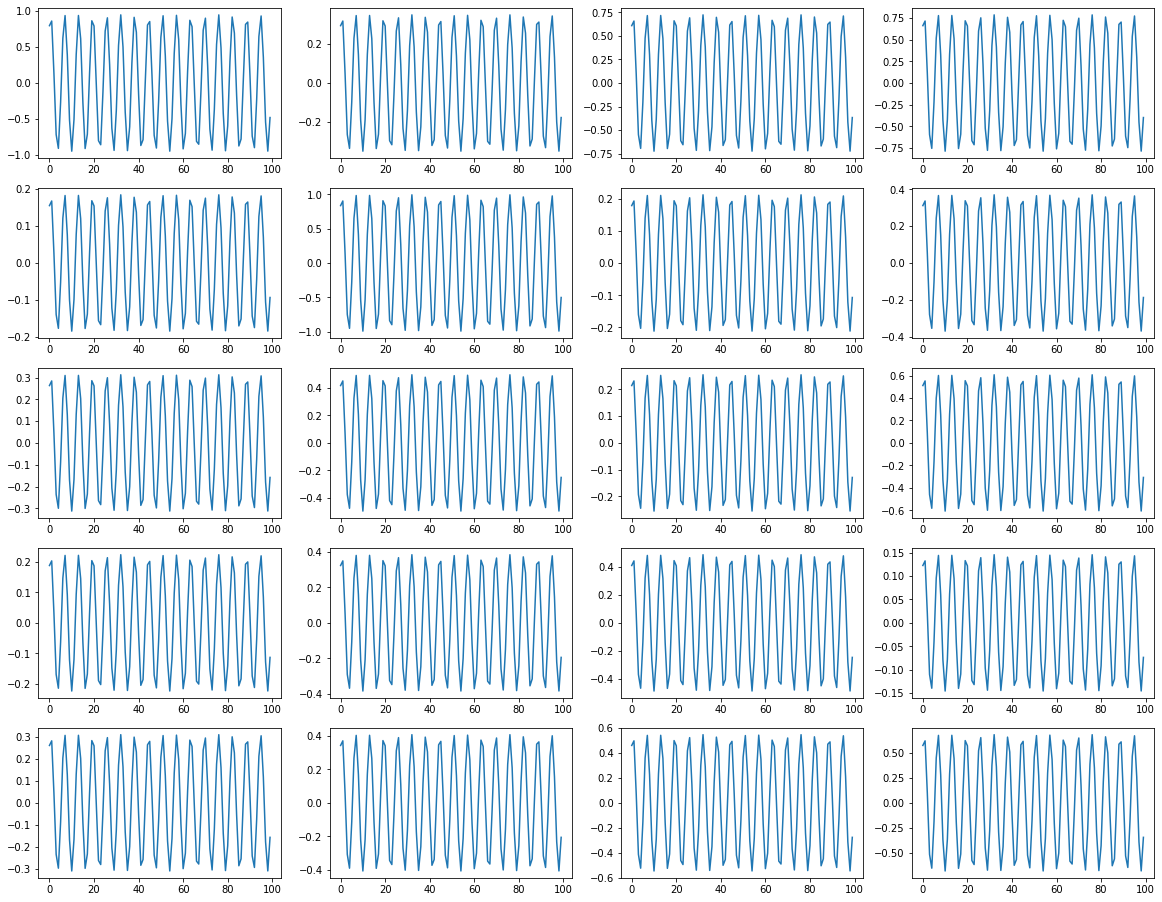

In [96]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5,4,figsize = (20,16))

for i in range(20):
    row = i // 4
    col = i % 4

    ax[row, col].plot(np.squeeze(signals[0][:100,i]))

## Tensorflow Model

In [107]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    [layers.MyInput(input_shape = (8000,20, 1)),
     tf.keras.layers.Conv1D(filters = 40, kernel_size = 5, strides = 2),
     tf.keras.layers.MaxPool1D(),
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(1, activation = "sigmoid")]
    )

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Functional)  (None, 8000, 20)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 3998, 40)          4040      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1999, 40)         0         
 1D)                                                             
                                                                 
 global_average_pooling1d_1   (None, 40)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-traina

In [108]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam"
)

In [110]:
model.fit(train_datagen)

2/2 [==============================] - 1s 43ms/step - loss: 0.6997
